In [4]:
!pip install nsepy ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29106 sha256=e69d4f3bb669079585f22b0ab40ce662fa915e0dde8cbd31d670ede14bf104c4
  Stored in directory: /root/.cache/pip/wheels/1b/81/50/db21d9643326c61dd6fee1dc2562d8351ee7753164c24ead38
Successfully built ta


In [85]:
import datetime
import numpy as np
import pandas as pd
from datetime import date
import plotly.express as px
from nsepy import get_history
import matplotlib.pyplot as plt
from ta.trend import EMAIndicator
from keras.models import Sequential
from ta.momentum import RSIIndicator 
from ta.volatility import BollingerBands
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

pd.options.mode.chained_assignment = None

Data Fetching

In [54]:
stock_name = input('Enter NSE Stock Name: ').upper()
start_date= datetime.date(2015, 1, 1)
end_date = date.today()
# get_history(symbol = 'SBIN', start=date(2015,1,1), end=date(2022,3,1))
def stock_df(s, sd, ed):
    df = get_history(symbol=s, start=sd, end=ed)
    return df

Enter NSE Stock Name: SBIN


In [56]:
data = stock_df(stock_name, start_date, end_date)
data.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2015-01-01,SBIN,EQ,311.85,312.45,315.00,310.70,314.0,314.00,313.67,6138488,1.925489e+14,58688,1877677,0.3059
2015-01-02,SBIN,EQ,314.00,314.35,318.30,314.35,315.6,315.25,316.80,9935094,3.147389e+14,79553,4221685,0.4249
2015-01-05,SBIN,EQ,315.25,316.25,316.80,312.10,312.8,312.75,313.84,9136716,2.867432e+14,88236,3845173,0.4208
2015-01-06,SBIN,EQ,312.75,310.00,311.10,298.70,299.9,299.90,305.14,15329257,4.677601e+14,169268,7424847,0.4844
2015-01-07,SBIN,EQ,299.90,300.00,302.55,295.15,301.4,300.15,299.95,15046745,4.513243e+14,147185,5631400,0.3743


Feature Selection and Extaction

In [86]:
df = data[['Open', 'High', 'Low', 'Close', 'Volume']]
df.reset_index(inplace=True)
df.drop(['Date'], axis=1, inplace=True)
df.head()

,Open,High,Low,Close,Volume
0,312.45,315.00,310.70,314.00,6138488
1,314.35,318.30,314.35,315.25,9935094
2,316.25,316.80,312.10,312.75,9136716
3,310.00,311.10,298.70,299.90,15329257
4,300.00,302.55,295.15,300.15,15046745


Train Test Split

In [58]:
train_df = pd.DataFrame(df.Close[0:int(len(df.Close)*0.75)])
test_df = pd.DataFrame(df.Close[int(len(df.Close)*0.75):int(len(df))])
train_df.shape, test_df.shape

((1471, 1), (491, 1))

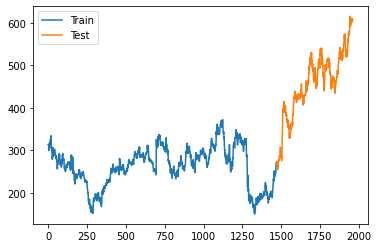

In [91]:
plt.plot(train_df)
plt.plot(test_df)
plt.legend(['Train', 'Test'])
plt.show()

In [60]:
train_df.head()

,Close
0,314.00
1,315.25
2,312.75
3,299.90
4,300.15


In [61]:
test_df.head()

,Close
1471,269.55
1472,272.45
1473,274.20
1474,270.65
1475,269.40


Feature Scaling

In [62]:
scaler = minmax_scaler = MinMaxScaler(feature_range=(0, 1))
train_df_scaled = scaler.fit_transform(train_df)
test_df_scaled = scaler.fit_transform(test_df)

X_train, y_train split

In [63]:
X_train = []
y_train = []
for i in range(100, len(train_df_scaled)):
    X_train.append(train_df_scaled[i-100 : i])
    y_train.append(train_df_scaled[i, 0])
len(X_train), len(y_train)

(1371, 1371)

In [64]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((1371, 100, 1), (1371,))

Model building and training

In [65]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, 
                input_shape=(X_train.shape[1], 1))) # input_shape=(timesteps, features)
model.add(Dropout(0.2))
#layer 2
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))
#layer 3
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.4))
#layer 4
model.add(LSTM(units=60, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(units = 1))


In [66]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 128)          66560     
                                                                 
 dropout_4 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm_5 (LSTM)               (None, 100, 100)          91600     
                                                                 
 dropout_5 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_6 (LSTM)               (None, 100, 60)           38640     
                                                                 
 dropout_6 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_7 (LSTM)               (None, 60)               

In [67]:
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=69)

Epoch 1/50
20/20 [==============================] - 17s 493ms/step - loss: 0.0646
Epoch 2/50
20/20 [==============================] - 9s 469ms/step - loss: 0.0203
Epoch 3/50
20/20 [==============================] - 9s 472ms/step - loss: 0.0149
Epoch 4/50
20/20 [==============================] - 9s 459ms/step - loss: 0.0148
Epoch 5/50
20/20 [==============================] - 9s 461ms/step - loss: 0.0134
Epoch 6/50
20/20 [==============================] - 9s 462ms/step - loss: 0.0140
Epoch 7/50
20/20 [==============================] - 9s 466ms/step - loss: 0.0129
Epoch 8/50
20/20 [==============================] - 9s 463ms/step - loss: 0.0121
Epoch 9/50
20/20 [==============================] - 9s 468ms/step - loss: 0.0105
Epoch 10/50
20/20 [==============================] - 9s 468ms/step - loss: 0.0105
Epoch 11/50
20/20 [==============================] - 9s 469ms/step - loss: 0.0101
Epoch 12/50
20/20 [==============================] - 9s 474ms/step - loss: 0.0105
Epoch 13/50
20/20 [=====

Creating X_test, y_test split and predicting the future values(Window size = 100)

In [68]:
train_df.tail(100)

,Close
1371,194.40
1372,192.00
1373,198.25
1374,191.95
1375,187.15
...,...
1466,256.30
1467,263.50
1468,269.60
1469,271.90


In [69]:
past_100 = train_df.tail(100)

In [70]:
final_df = past_100.append(test_df, ignore_index=True)
final_df.head()

,Close
0,194.40
1,192.00
2,198.25
3,191.95
4,187.15


In [71]:
input_data = scaler.fit_transform(final_df)
len(input_data)

591

In [72]:
X_test = []
y_test = []
for i in range(100, len(input_data)):
    X_test.append(input_data[i-100 : i])
    y_test.append(input_data[i, 0])

In [73]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((491, 100, 1), (491,))

Prediction

In [74]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

43/43 [==============================] - 4s 88ms/step


Feature Scaling for Model Evalution

In [75]:
scaler.scale_

array([0.00227687])

In [76]:
scale_factor = 1/scaler.scale_
y_pred = y_pred*scale_factor
y_test = y_test*scale_factor

y_train_pred = y_train_pred*scale_factor
y_train = y_train*scale_factor
y_pred.shape, y_test.shape

((491, 1), (491,))

Model Evaluation

In [77]:
import math
from sklearn.metrics import mean_absolute_error
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
t_rmse = math.sqrt(mean_squared_error(y_train, y_train_pred))
t_mae = mean_absolute_error(y_train, y_train_pred)
t_rmse, t_mae
print('Training RMSE: ', t_rmse)
print('Training MAE: ', t_mae)
print('Testing RMSE: ', rmse)
print('Testing MAE: ', mae)

Training RMSE:  19.965839271169305
Training MAE:  14.77252405827105
Testing RMSE:  16.250477803451464
Testing MAE:  12.382724772014367


Training Plot

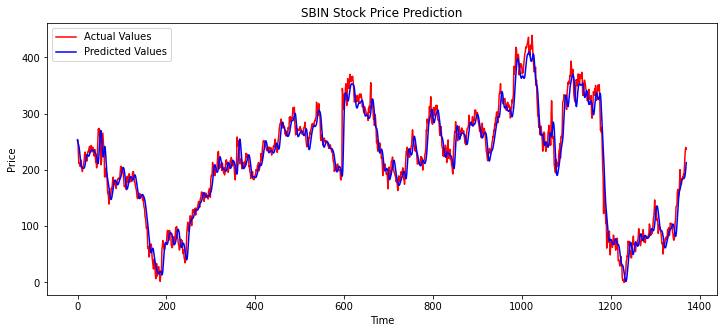

In [78]:
plt.figure(figsize=(12,5))
plt.plot(y_train, color='red', label='Actual Values')
plt.plot(y_train_pred, color='blue', label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{stock_name} Stock Price Prediction')
plt.legend(loc='upper left')

Testing Plot

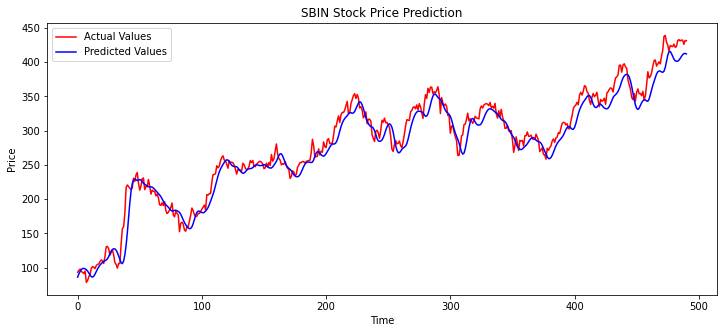

In [79]:
plt.figure(figsize=(12,5))
plt.plot(y_test, color='red', label='Actual Values')
plt.plot(y_pred, color='blue', label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{stock_name} Stock Price Prediction')
plt.legend(loc='upper left')

# Technical Analysis

In [87]:
d = stock_df(stock_name, start_date, end_date)
df = d[['Open', 'High', 'Low', 'Close', 'Volume']]
df

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-01,312.45,315.00,310.70,314.00,6138488
2015-01-02,314.35,318.30,314.35,315.25,9935094
2015-01-05,316.25,316.80,312.10,312.75,9136716
2015-01-06,310.00,311.10,298.70,299.90,15329257
2015-01-07,300.00,302.55,295.15,300.15,15046745
...,...,...,...,...,...
2022-11-28,605.60,610.90,602.35,608.60,7934274
2022-11-29,607.10,611.80,607.10,608.55,6942919
2022-11-30,608.50,611.40,598.40,602.45,15606230


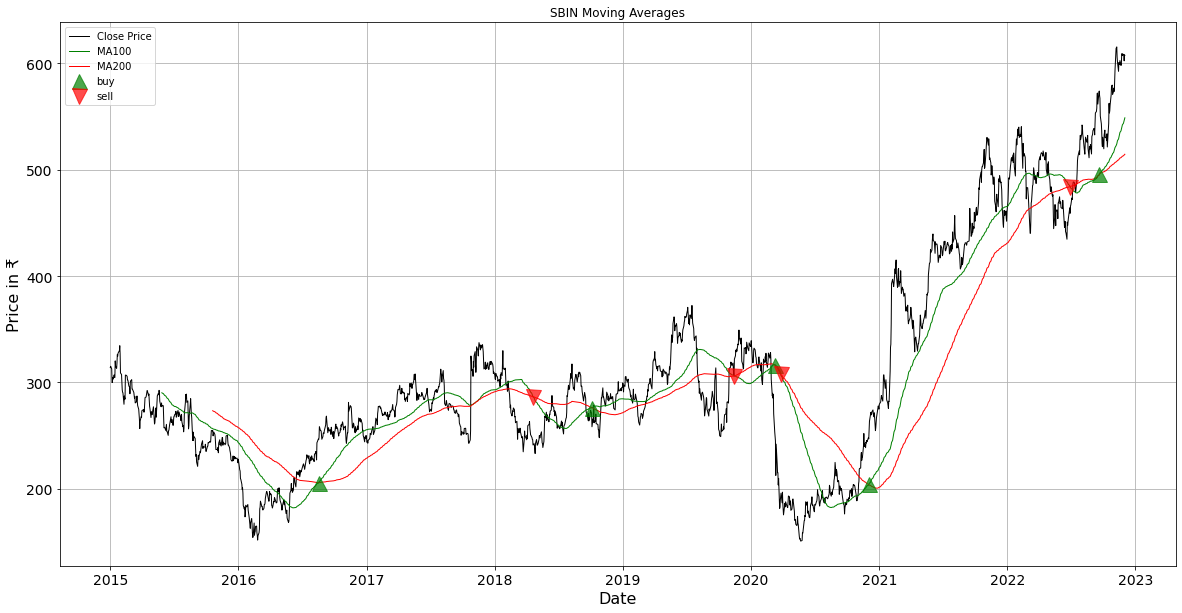

In [88]:
# Indicator 1 - Momentum
# Moving Averages
def moving_average(df, short_window = 100, long_window = 200):
    df.loc[:,'MA100'] = df['Close'].rolling(short_window).mean()
    df.loc[:,'MA200'] = df['Close'].rolling(long_window).mean()
    df.loc[:,'MA20'] = df['Close'].rolling(20).mean()
    df.loc[:,'Signal'] = 0
    df.loc[:,'Signal'] = np.where(df['MA100'] > df['MA200'], 1, 0)
    df.loc[:,'Position'] = df['Signal'].diff()

    plt.figure(figsize = (20,10))
    plt.tick_params(axis = 'both', labelsize = 14)
    df['Close'].plot(color = 'k', lw = 1, label = 'Close Price')  
    df['MA100'].plot(color = 'g', lw = 1, label = 'MA100')
    df['MA200'].plot(color = 'r', lw = 1, label = 'MA200') 

    # plot 'buy' signals
    plt.plot(df[df['Position'] == 1].index, 
            df['MA100'][df['Position'] == 1], 
            '^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy')

    # plot 'sell' signals
    plt.plot(df[df['Position'] == -1].index, 
            df['MA100'][df['Position'] == -1], 
            'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')
    plt.ylabel('Price in ₹', fontsize = 16 )
    plt.xlabel('Date', fontsize = 16 )
    plt.title(f'{stock_name} Moving Averages')
    plt.legend()
    plt.grid()
    plt.show()

moving_average(df)

In [82]:
# Indicator 2 - Momentum
# Relative Strength Index
rsi = RSIIndicator(df['Close'], 14).rsi()
def relative_strength_index(df, rsi):
    if(rsi[-7:].mean() > 80):
        print('Alert : Do Not buy this stock, market value exceeded 80%')
    if(rsi[-7:].mean() < 20):
        print('Alert : Do Not sell this stock, market value below 20%')
    else:
        if(rsi[-7:].mean() > 50):
            return 'Prefer Buy'
        elif(rsi[-7:].mean() < 50):
            return 'Prefer Sell'
        else:
            return 'Prefer Hold'
    
relative_strength_index(df, rsi)

'Prefer Buy'

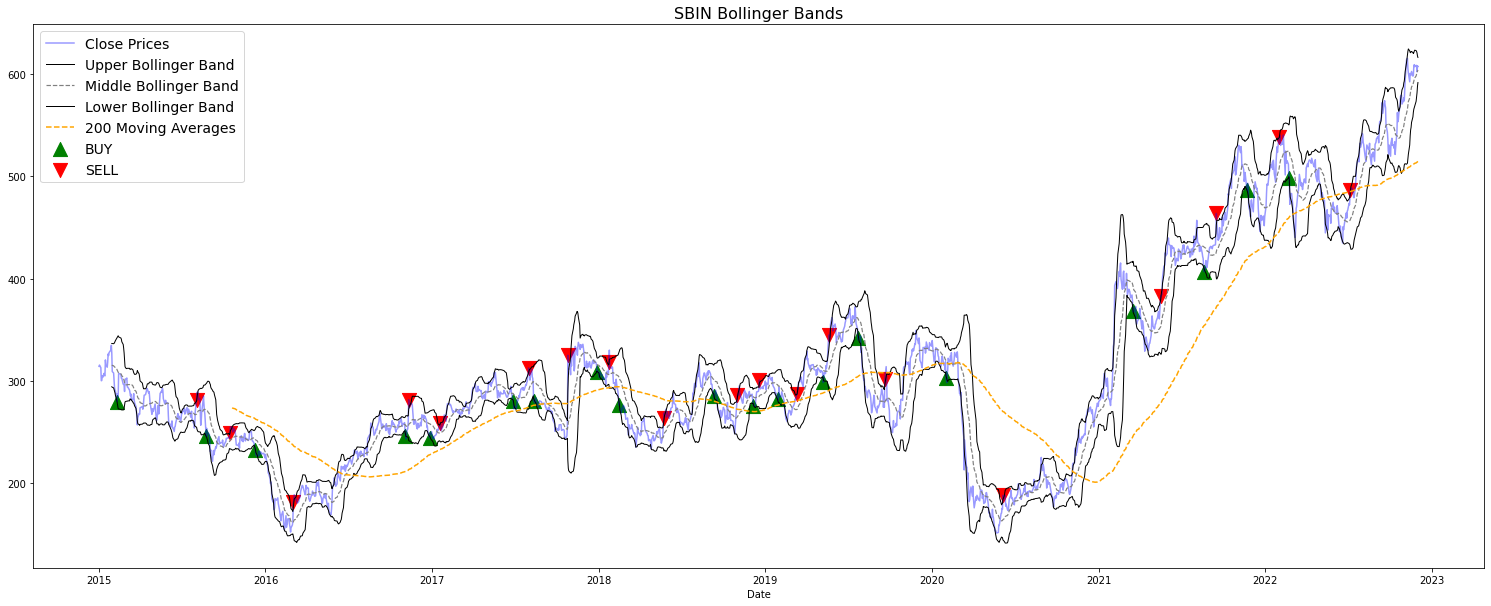

In [89]:
# Indicator - 3 Volatility
# Bollinger Bands
def bb(data, sma, window = 20):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

df.loc[:,'upper_bb'], df.loc[:,'lower_bb'] = bb(df['Close'], df['MA20'])

def bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

buy_price, sell_price, bb_signal = bb_strategy(df['Close'], df['lower_bb'], df['upper_bb'])
plt.figure(figsize=(26,10))
df['Close'].plot(label = 'Close Prices', alpha = 0.4, color = 'blue')
df['upper_bb'].plot(label = 'Upper Bollinger Band', linewidth = 1, color = 'black')
df['MA20'].plot(label = 'Middle Bollinger Band', linestyle = '--', linewidth = 1.2, color = 'grey')
df['lower_bb'].plot(label = 'Lower Bollinger Band', linewidth = 1, color = 'black')
df['MA200'].plot(label = '200 Moving Averages', linestyle = '--', linewidth = 1.5, color = 'orange')
plt.scatter(df.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(df.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.title(f'{stock_name} Bollinger Bands', fontsize = 16)
plt.legend(loc = 'upper left', fontsize = 14)
plt.show()

Text(0.5, 1.0, 'SBIN Exponential Moving Averages')

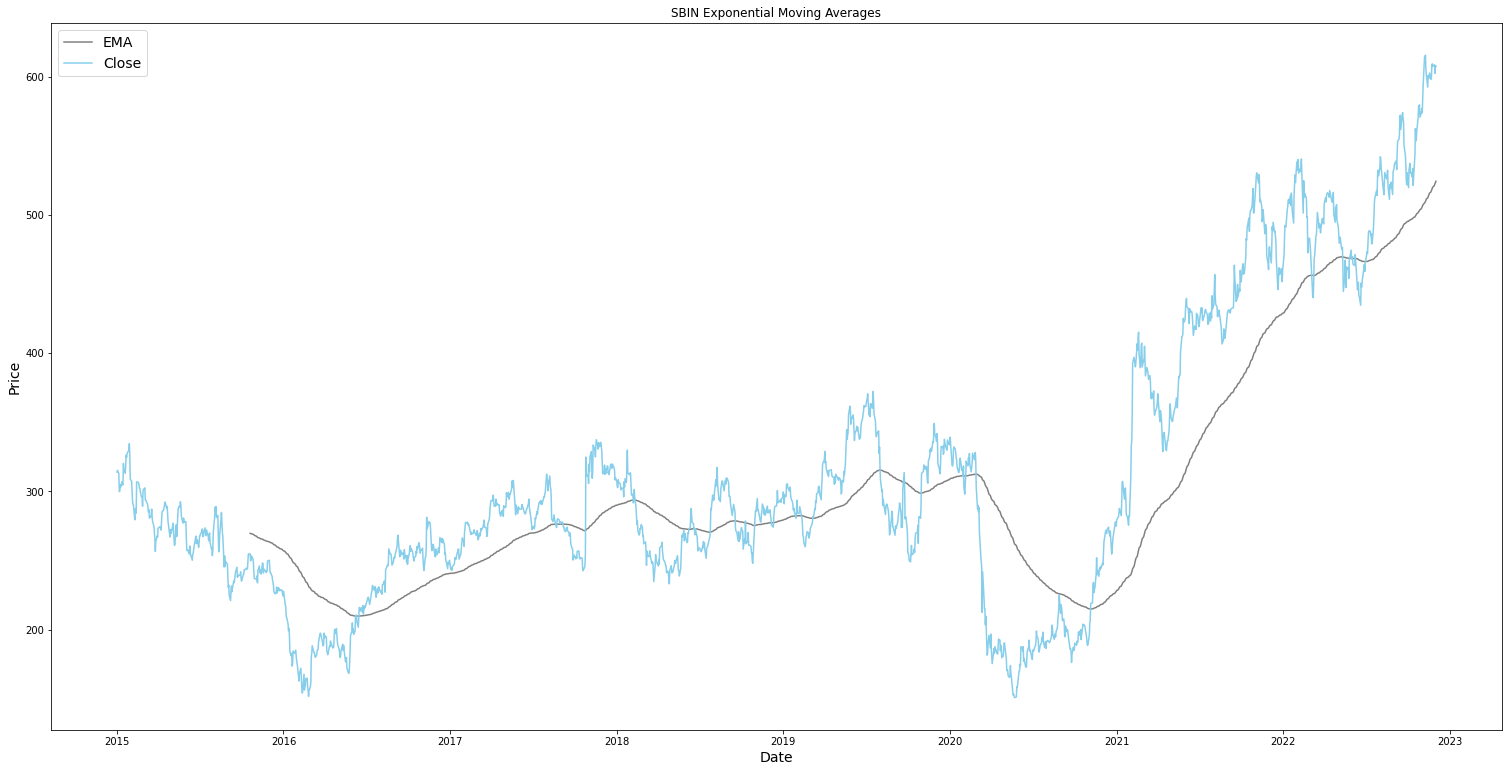

In [90]:
# Indicator - 4 Momentum
# Exponential Moving Averages
ema = EMAIndicator(df['Close'], 200)
df.loc[:,'EMA'] = ema.ema_indicator()
def addemasignal(df, backcandles):
    emasignal = [0]*len(df)
    for row in range(backcandles, len(df)):
        upt = 1
        dnt = 1
        for i in range(row-backcandles, row+1):

            if df.High[i]>=df.EMA[i]:
                dnt=0
            if df.Low[i]<=df.EMA[i]:
                upt=0

        if upt==1 and dnt==1:
            emasignal[row]=3
        elif upt==1:
            emasignal[row]=2
        elif dnt==1:
            emasignal[row]=1
    df['EMASignal'] = emasignal

addemasignal(df,6)
df.EMA.plot(color = 'grey', linewidth = 1.5, label = 'EMA', figsize = (26,13))
df.Close.plot(color = 'skyblue', linewidth = 1.5, label = 'Close')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 14)
plt.title(f'{stock_name} Exponential Moving Averages')